<a href="https://colab.research.google.com/github/stefanogiagu/PHDMIB_2025/blob/main/notebooks/PyTorch_SimpleMLP_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Implementation of a basic pytorch MLP shallow architecture to illustrate
# a tipical DL pipeline implemented in pytorch
#
# Stefano Giagu - v1.3 - 16.6.2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [3]:
# in torch/pytorch data and models need to be moved in the specific processing unit
# this code snippet allows to set the variable "device" according to available resoirce (cpu or cuda gpu)

if torch.cuda.is_available():
  print('number fo devices: ', torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
  !nvidia-smi
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

number fo devices:  1
Tesla T4
Mon Jun 16 17:16:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------

In [4]:
# Dataset: in this simple example, we'll produce a toy dataset generated using
# numpy
#
# two class problem, with 8 uncorrelated features, gaussian distributed with different
# means and variance among features and classes

meanS = [-4.,-3.,-2.,-1.,1.,2.,3.,4.]
meanB = [-4.5,-3.5,-2.5,-1.5,1.5,2.5,3.5,4.5]
features_S = np.random.normal(loc=meanS, scale=np.random.uniform(0.2,0.7,size=(8)), size=(4000,8))
features_B = np.random.normal(loc=meanB, scale=np.random.uniform(0.2,0.7,size=(8)), size=(4000,8))
labels_S = np.zeros(shape=(4000))
labels_B = np.ones(shape=(4000))

X = np.concatenate((features_S, features_B), axis=0)
Y = np.concatenate((labels_S, labels_B), axis=0)

# divide the dataset in train and test
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12345)
X_test, X_vali, Y_test, Y_vali = train_test_split(X_test, Y_test, test_size=0.5, random_state=456789)
print(X_train.shape)
print(Y_train.shape)
print(X_vali.shape)
print(Y_vali.shape)
print(X_test.shape)
print(Y_test.shape)

(6400, 8)
(6400,)
(800, 8)
(800,)
(800, 8)
(800,)


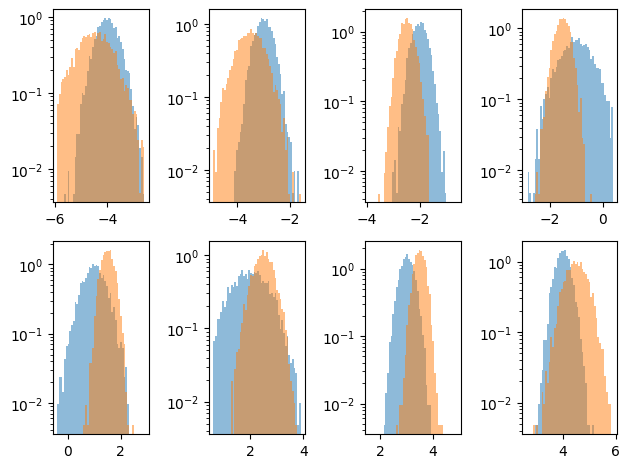

In [5]:
# plot variables

sel_S = tuple([Y_train<0.5])
sel_B = tuple([Y_train>0.5])

for idx in range(8):
  plt.subplot(2,4,idx+1)
  minr = min(meanS[idx],meanB[idx])
  maxr = max(meanS[idx],meanB[idx])
  plt.hist((X_train[sel_S])[:,idx], bins=50, range=[minr-1.4,maxr+1.4], alpha=0.5, log=True, density=True)
  plt.hist((X_train[sel_B])[:,idx], bins=50, range=[minr-1.4,maxr+1.4], alpha=0.5, log=True, density=True)
plt.tight_layout()

In [6]:
# transform the numpy arrays to torch tensors (pytorch works with torch tensors)

X_train_pt = torch.Tensor(X_train).float()
Y_train_pt = torch.Tensor(Y_train).float()
X_vali_pt = torch.Tensor(X_vali).float()
Y_vali_pt = torch.Tensor(Y_vali).float()
X_test_pt = torch.Tensor(X_test).float()
Y_test_pt = torch.Tensor(Y_test).float()

print(X_train_pt.shape)
print(Y_train_pt.shape)
print(X_vali_pt.shape)
print(Y_vali_pt.shape)
print(X_test_pt.shape)
print(Y_test_pt.shape)

# create a pytorch dataset and a pytroch dataloader (a python iterable that allows to iterate among sample's events
# mini-batch it, reshuffle at every epoch, etc...)
from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train_pt, Y_train_pt)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_vali = TensorDataset(X_vali_pt, Y_vali_pt)
dataloader_vali = DataLoader(dataset_vali, batch_size=32, shuffle=True)

torch.Size([6400, 8])
torch.Size([6400])
torch.Size([800, 8])
torch.Size([800])
torch.Size([800, 8])
torch.Size([800])


In [7]:
# note: move torch tensors between cpu and gpu

print('X_train_pt is in GPU: ', X_train_pt.is_cuda)
X_train_pt = X_train_pt.to(device)
print('X_train_pt is in GPU: ', X_train_pt.is_cuda)
X_train_pt = X_train_pt.to('cpu')
print('X_train_pt is in GPU: ', X_train_pt.is_cuda)


# alteranative way (earlier torch style)
# use .cuda() e .cpu()
print('X_train_pt is in GPU: ', X_train_pt.cpu())
print('X_train_pt is in GPU: ', X_train_pt.cuda())

X_train_pt is in GPU:  False
X_train_pt is in GPU:  True
X_train_pt is in GPU:  False
X_train_pt is in GPU:  tensor([[-5.1456, -4.1152, -2.8060,  ...,  2.6085,  3.8572,  4.3653],
        [-3.6925, -3.4780, -1.5316,  ...,  0.9972,  2.9023,  3.3483],
        [-3.1660, -4.4137, -2.6901,  ...,  1.9892,  3.7497,  4.6869],
        ...,
        [-5.2636, -3.9224, -2.5298,  ...,  2.6543,  3.6800,  4.4259],
        [-2.8539, -3.6823, -1.7327,  ...,  1.7245,  3.2554,  3.5639],
        [-4.0743, -3.6302, -2.6765,  ...,  3.0973,  3.5256,  4.5674]])
X_train_pt is in GPU:  tensor([[-5.1456, -4.1152, -2.8060,  ...,  2.6085,  3.8572,  4.3653],
        [-3.6925, -3.4780, -1.5316,  ...,  0.9972,  2.9023,  3.3483],
        [-3.1660, -4.4137, -2.6901,  ...,  1.9892,  3.7497,  4.6869],
        ...,
        [-5.2636, -3.9224, -2.5298,  ...,  2.6543,  3.6800,  4.4259],
        [-2.8539, -3.6823, -1.7327,  ...,  1.7245,  3.2554,  3.5639],
        [-4.0743, -3.6302, -2.6765,  ...,  3.0973,  3.5256,  4.5674]],


In [8]:
# example of iteration through the dataloader

train_features, train_labels = next(iter(dataloader_train))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

an_event = train_features[0].squeeze()
a_label = train_labels[0]

print(f"Feature: {an_event}")
print(f"Label: {a_label}")

Feature batch shape: torch.Size([32, 8])
Labels batch shape: torch.Size([32])
Feature: tensor([-5.1501, -2.8104, -2.7603, -1.0159,  1.2470,  2.5063,  3.8637,  4.9763])
Label: 1.0


In [9]:
# a pytorch nn model: it is just a python class inheriting from nn.Module that defines
# the layers and activations used in the DNN model and a forward(x) method that defines
# how the model act on an input example x

from torch import nn
import torch.nn.functional as F

# as a basic example let'd define a shallow ANN with a dense layer with 20 neurons
class ShallowANN(nn.Module):
  def __init__(self, input_dim):
    super(ShallowANN, self).__init__()

    #torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
    #Linear in pytorch is the equivalent of Dense in keras
    self.layer1 = nn.Linear(input_dim, 20)
    self.activ1 = nn.ReLU()
    self.layer2 = nn.Linear(20, 1)
    self.activ2 = nn.Sigmoid()

  def forward(self, x):
    out = self.layer1(x)
    out = self.activ1(out)
    out = self.layer2(out) #alternatively the two statements can be replaced
    out = self.activ2(out) #out = torch.sigmoid(self.layer2(out))
    return out

# note: it is strightfoward to modify the class to implement a MLP

# example MLP: with 3 hidden layers

class MyMLP(nn.Module):
  def __init__(self):
    super(MyMLP, self).__init__()

    self.layer1 = nn.Linear(8, 20)
    self.activ1 = nn.ReLU()
    self.layer2 = nn.Linear(20, 50)
    self.activ2 = nn.ReLU()
    self.layer3 = nn.Linear(50, 100)
    self.activ3 = nn.ReLU()
    self.layer4 = nn.Linear(100, 1)
    self.activ4 = nn.Sigmoid()

  def forward(self, x):
    out = self.layer1(x)
    out = self.activ1(out)
    out = self.layer2(out)
    out = self.activ2(out)
    out = self.layer3(out)
    out = self.activ3(out)
    out = self.layer4(out)
    out = self.activ4(out)
    return out


# alternative implementation using nn.Sequential()
class MyMLP2(nn.Module):
  def __init__(self):
    super(MyMLP2, self).__init__()

    self.mlp_block = nn.Sequential( #similar to keras keras.Sequential module
      nn.Linear(8, 20),
      nn.ReLU(),
      nn.Linear(20, 50),
      nn.ReLU(),
      nn.Linear(50, 100),
      nn.ReLU()
    )

    self.out_block = nn.Linear(100, 1)

  def forward(self, x):
    out = torch.sigmoid(self.out_block(self.mlp(x)))
    return out

In [ ]:
#%pip install torchsummary #already installed in google colab

In [10]:
model = ShallowANN(input_dim=8)
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,8))
else:
  summary(model, input_size=(1,8))

ShallowANN(
  (layer1): Linear(in_features=8, out_features=20, bias=True)
  (activ1): ReLU()
  (layer2): Linear(in_features=20, out_features=1, bias=True)
  (activ2): Sigmoid()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 20]             180
              ReLU-2                [-1, 1, 20]               0
            Linear-3                 [-1, 1, 1]              21
           Sigmoid-4                 [-1, 1, 1]               0
Total params: 201
Trainable params: 201
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [11]:
#install torchmetrics: collection of useful PyTorch metrics implementations and an easy-to-use API to create custom metrics]
%pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [12]:
# reinstantiate a new model (reset weight etc) and put it on GPU
model = ShallowANN(input_dim=8)
model.to(device)
print('model is on GPU: ',next(model.parameters()).is_cuda)

model is on GPU:  True


In [15]:
#loss

# NOTE: BCELoss for binary classification
#       CrossEntropyLoss for multiclass classification (already includes softmax calculation, output the ANN foward method must be logits)
loss_func = nn.BCELoss() #binary cross entropy loss

# metrics
import torchmetrics
from torchmetrics.classification import BinaryAccuracy

#metric binary accuracy (hand's made)
def my_binary_accuracy(yhat, y):
  assert y.ndim == 1 and y.size() == yhat.size()
  yhat = yhat > 0.5
  return (y == yhat).sum().item() / y.size(0)

# NOTE: better to use metrics from torchmetrics:
my_metric_func = BinaryAccuracy()
my_metric_func.to(device)

# optim
from torch import optim
#opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# alternative

opt = optim.Adam(model.parameters(), lr=1e-3)

# scheduler for multi step decay lr schedule
# Decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones
#lr_scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[20,40,60], gamma=0.1)

In [14]:
# test implementation on one batch before to train
xb,yb = next(iter(dataloader_train))

xb=xb.type(torch.float).to(device) #put tensors on device
yb=yb.type(torch.float).to(device)

# prediction

pred = model(xb)
print('output shape: ', pred.shape)

# loss and metric
loss = loss_func(pred, torch.unsqueeze(yb,1))
#metric = binary_accuracy(pred, torch.unsqueeze(yb,1))
#or also: metric = binary_accuracy(torch.squeeze(pred), yb)
metric = my_metric_func(torch.squeeze(pred), yb)
mymetric = my_binary_accuracy(torch.squeeze(pred), yb)

print('loss: ', loss.item())
print('metric: ', metric.item())
print('my_metric: ', mymetric)

output shape:  torch.Size([32, 1])
loss:  0.7033722996711731
metric:  0.5
my_metric:  0.5


In [16]:
#training loop (in pytorch you need to write yourself it (alternatively use PyTorch Lightning for more keras-like APIs))
import time
epochs = 200

# define a couple of lists to store loss and accuracy during training for monitorin purposes
hist_loss = []
hist_metric = []
hist_val_loss = []
hist_val_metric = []

# loop over epochs
for epoch in range(epochs):
    t0 = time.time()

    #training step
    model.train() #important!
    train_loss = 0.0
    train_metric = 0.0
    counter = 0
    for xb, yb in dataloader_train: #loop over minibatches
        counter += 1
        xb=xb.type(torch.float).to(device)
        yb=yb.type(torch.float).to(device)
        pred = model(xb)
        loss = loss_func(pred, torch.unsqueeze(yb,1))
        metric = my_metric_func(pred, torch.unsqueeze(yb,1))
        train_loss += loss.item()
        train_metric += metric.item()

        # backpropagation
        loss.backward()
        opt.step()
        opt.zero_grad()

    train_loss = train_loss/counter
    train_metric = train_metric/counter

    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

    # validation step
    model.eval() #important!
    vali_loss = 0.0
    vali_metric = 0.0
    counter = 0
    with torch.no_grad():
      for xb, yb in dataloader_vali:
        counter += 1
        xb=xb.type(torch.float).to(device)
        yb=yb.type(torch.float).to(device)
        pred = model(xb)
        vloss = loss_func(pred, torch.unsqueeze(yb,1))
        vmetric = my_metric_func(pred, torch.unsqueeze(yb,1))
        vali_loss += vloss.item()
        vali_metric += vmetric.item()

    vali_loss = vali_loss/counter
    vali_metric = vali_metric/counter

    hist_val_loss.append(vali_loss)
    hist_val_metric.append(vali_metric)

    elapsed_time = time.time()-t0
    #current_lr = lr_scheduler.get_last_lr()[0]
    #print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f, lr : %1.2e"
    #      % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric, current_lr))
    print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f"
          % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))

    # update learning rate schedule
    #lr_scheduler.step()

epoch: 1, time(s): 0.8979, train loss: 0.664452, train metric: 0.600938, vali loss: 0.624745, vali metric: 0.785000
epoch: 2, time(s): 0.6009, train loss: 0.588684, train metric: 0.756250, vali loss: 0.541916, vali metric: 0.796250
epoch: 3, time(s): 0.5969, train loss: 0.519533, train metric: 0.791562, vali loss: 0.482329, vali metric: 0.826250
epoch: 4, time(s): 0.5983, train loss: 0.471379, train metric: 0.807031, vali loss: 0.444798, vali metric: 0.833750
epoch: 5, time(s): 0.6044, train loss: 0.437252, train metric: 0.817969, vali loss: 0.417653, vali metric: 0.842500
epoch: 6, time(s): 0.5826, train loss: 0.413290, train metric: 0.831562, vali loss: 0.402695, vali metric: 0.831250
epoch: 7, time(s): 0.5973, train loss: 0.393397, train metric: 0.837969, vali loss: 0.379294, vali metric: 0.847500
epoch: 8, time(s): 0.5757, train loss: 0.375183, train metric: 0.847344, vali loss: 0.363090, vali metric: 0.848750
epoch: 9, time(s): 0.6097, train loss: 0.357636, train metric: 0.859688,

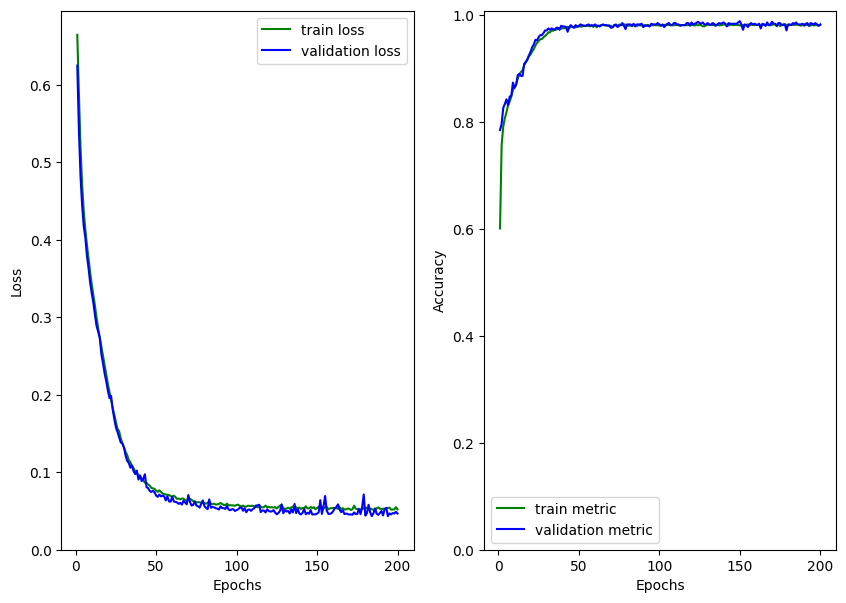

In [17]:
# plot training results (loss and accuracy vs epoch)
plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_val_loss)+1), hist_val_loss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(ymin = 0.0)
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1), hist_metric,  color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_val_metric)+1),hist_val_metric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(ymin = 0.0)
plt.legend()

In [18]:
#test the trained model

# let's test it on cpu
model.to(torch.device("cpu"))

X_test_pt = X_test_pt.type(torch.float).to(torch.device("cpu"))
res = model(X_test_pt)

In [19]:
print('Test accuracy: ',my_metric_func(res, torch.unsqueeze(Y_test_pt,1)).item())

Test accuracy:  0.9887499809265137
